# 3D Pose Estimation and Objectron for object detection

## Brief
- Outline:
    - 3D bounding box detection on 2D images
    - Estimation of world coordinates of the camera
    - Human Pose Detection
    - Projection of 2D pose estimation to 3D world coordinates
    - Intersection between Pose and Objectron
        

## Overview
The goal of this project is to let you experience working with state-of-the-art libraries and real-time processing of video. We will be working with [MediaPipe](https://google.github.io/mediapipe/), which offers customizable Machine Learning solutions for live media. Specifically, we will use: [pose estimation](https://google.github.io/mediapipe/solutions/pose), which estimates the pose of a person in real time; and [objectron](https://google.github.io/mediapipe/solutions/objectron.html), which is a 3D object detector from 2D images. We will try to identify an object that is being touched by a person with these tools.

## Imports

In [349]:
%reload_ext autoreload
%autoreload 2

import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2

import tools
import utils

## 3D bounding box detection on 2D images

We're going to use mediapipe's [objectron](https://google.github.io/mediapipe/solutions/objectron) library based on this [paper](https://arxiv.org/pdf/2003.03522.pdf) to detect 3D bounding boxes of chairs in images.

Basically, there is an encoder and a decoder for the detection part. The encoder takes an image as input, analyzes it, and gives some useful information in a certain form. Then the decoder takes these intermediate information as input, translates them into things we want (i.e., 8 vertices' 2D coordinates).
The encoder is trained as a neural network, whose weight file is provided and can be read by Tensorflow (which is the `inference()` function in `my_objectron.py`). The decoder part is implemented as the `decode()` function in `my_objectron.py`.

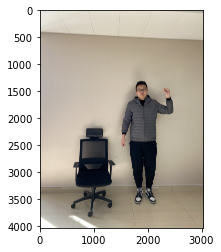

In [366]:
# Reading test image
student_test_img='../data/9.jpg'
img = cv2.imread(student_test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Now we use `detect_3d_box()` in `tools.py` in the following cell.

[[1, 3, 640, 480]] [[1, 16, 40, 30], [1, 1, 40, 30]]
0.9269704222679138


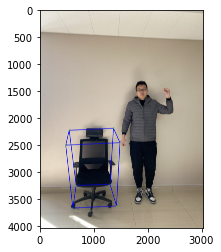

In [367]:
bounding_boxes_chair_2d, annotated_img = student_code.detect_3d_box(student_test_img)
plt.imshow(annotated_img)
plt.show()

## Estimation of world coordinates of the camera

### Establish the world coordinate frame

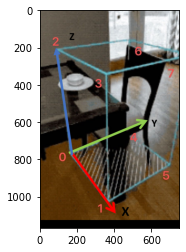

In [369]:
# Read test image
img_index = cv2.imread('../data/world_frame.png')
img_index = cv2.cvtColor(img_index, cv2.COLOR_BGR2RGB)
plt.imshow(img_index)
plt.show()

Similar to project 5, we want to estimate the intrinsic camera matrix, but this time we will provide an initial estimation for a cube, giving 8 vertices in 3D coordinate. In this coordinate system, we define 0 as the `origin`, 0-1 as the `x-axis`, 0-4 as the `y-axis`, and 0-2 as the `x-axis`.

Then, we need to estimate the dimensions of the chair to calculate the location of the coordinates in the world frame.

In [370]:
# Here we need to measure the size of chair at first, and set their values there. 
# For example, the example chair's size is 0.4m * 0.4m *1.0m
size_x = 0.4
size_y = 0.4
size_z = 1.0
vertices_world = tools.get_world_vertices(size_x, size_y, size_z)

initial_box_points_3d = vertices_world

Testing your get_world_vertices:  "Correct"


### Estimate intrinsic matrix of your camera

 We can use a convenient function from [OpenCV](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) to help calibrate our camera, without writing calibration camera function, by taking pictures of a chessboard from various angles (better > 10).


The `calibrate()` function in `utils.py` requires the number of grids. If you use the checkerboard provided in the `data` folder, you can simply use the default parameters. If you want to try your own checkerboard, please note that the part used for calibration is two subgrids smaller than the actual in both x and y direction. For example, the example picture, the checkerboard has 5 x 8 subgrids, then the part used for calibration should be 3 x 6, thus the number of vertices should be 4 x 7 (corresponding to m and n in `calibrate` function).

About what is the mechanism in calibrating a camera with checkerboard, please refer to [WiKi- Camera Calibration](https://en.wikipedia.org/wiki/Chessboard_detection#:~:text=Chessboard%20camera%20calibration,-A%20classical%20problem&text=Chessboards%20are%20often%20used%20during,interest%20points%20in%20an%20image.) and [OpenCV Doc](https://docs.opencv.org/3.4/d4/d94/tutorial_camera_calibration.html)

Important tips:
- Take pictures from different angles, and avoid very similar pictures
- Use the pictures of the same resolution for all the tasks; Usually, phone camera uses different zoom for taking pictures and record videos. 
- By default, phone cameras usually adjust focal length automatically.

In [371]:
from utils import calibrate

path2 = '../data/cali2/example2/' # update the path to where you save the pictures
m = 5 # m is the vertice number in x direction
n = 7 # n is the vertice number in y direction

K = calibrate(path2)

../data/cali2/example2/*.jpg
[[1.11573975e+03 0.00000000e+00 7.22275004e+02]
 [0.00000000e+00 1.06794751e+03 5.31184727e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


###  Estimate camera pose

After getting the 8 vertices of the box in 2D coordinate and the camera intrinsic matrix, we can recover the projection matrix by method called perspective-n-point method. Perspective-n-Point is a typical problem in 3D geometry estimating the pose of a calibrated camera given `n` 3D points in world and their corresponding 2D projected points on image frame. There are several way to get the projection matrix given the 2D-3D correspondence.

* **Direct Linear Transform (DLT)**, we use this method when we are working with camera calibration to solve the projection matrix. Remember in that project, we mentioned P has 11 DoF, thus we need at least 6 correspondencse to get the P. But this method has limitation on accuracy because it uses SVD to solve the P as a 12x1 vector ignoring the inner connection of all 12 parameters.

* **Perspective-3-Point (P3P)**, is the minimal form of PnP problem. This method uses the law of cosines to give extra constraints of the 6 triangles (3 similar triagle pairs) formed by the 3 correspondence and camera center. This method has disadvantages of limitation on information given only by three correspondence. Besides, when there are noises in the three correspondence, it is not robust.

* **Perspective-n-Point (PnP)**, is a often used pose estimation method which is more robust. Use the projection model, we can define the reprojection error, which is the difference between the projected 3D points and their matched 2D points, here the intrinsic matrix K should be known. Then given an initial estimation of camera pose, you can solve the problem by using nonlinear optimization. Give some perturbation to the intial estimation and then calculate the jacobian and hessian matrix, then you can get a update on your intial estimation. Repeat the process untill the error converges, you will get a well optimized camera pose. For this part, please refer to the [Wiki-Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) to know more.

**Note:** The rotation and translation returned by cv2.solvePnP is different with what we deal with in project4. In project4, we use the notations below:

- ${}^wR_c$: for rotation of the camera in the world coordinate frame
- ${}^wt_c$: for translation of the camera in the world coordinate frame, which is the **camera_center**
- ${}^cR_w$: ${}^cR_w = {{}^wR_c}^T$

The projection matrix **P**

\begin{align}
\mathbf
{P}=  \mathbf{K} \: {}^w \mathbf{R}_c^\top [ \mathbf{I}\;|\; -{}^w \mathbf{t}_c ] =
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

And this transform from world coordinate to camera coordinate:

$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = \begin{bmatrix}\mathbf{{}^wR_c^T} & -\mathbf{{}^wR_c^T}\ {}_w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}\begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

**In opencv**, The translation $tvec$ and rotation part $rvec$ returned by `cv2.solvePnP()` is 

\begin{align}
tvec = \begin{bmatrix} t_1 & t_2 & t_3 \end{bmatrix} ^T
\end{align}

\begin{align}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix} = Rodrigues Transform (rvec)
\end{align}

Another form to perform the transformation from world coordinate to camera coordinate is use the ${}^c{T}_w$ matrix,

$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = {}^c{T}_w \begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

\begin{align}
\mathbf
{}^c{T}_w=
\begin{bmatrix}
r_{11} & r_{21} & r_{31} & t_1 \\
r_{12} & r_{22} & r_{32} & t_2 \\
r_{13} & r_{23} & r_{33} & t_3 \\
0 & 0 & 0 & 1
\end{bmatrix} = \begin{bmatrix}\mathbf{{}^wR_c^T} & -\mathbf{{}^wR_c^T}\ {}^w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}
\end{align}

Therefore, to get the ${}^wR_c$, projection matrix $\textbf{P}$ and camera center ${}^wt_c$ from `tvec` and `rvec`, you need to transform it by:

$$ {{}^wR_c}^T = Rodrigues Transform (rvec) $$

$$ P = K * \begin{bmatrix} {{}^wR_c}^T & tvec \end{bmatrix} $$

$$ {}^wt_c = - {{}^wR_c} * tvec $$

In this project, we do not need to implement the PnP method yourself, we can call the function from `cv2.solvePnP` directly. After getting the tvec and rvec from cv2.solvePnP, we need to return the ${}^w \mathbf{R}_c^\top$, the camera center in world coordinate and the projection matrix $\textbf{P}$.


In [372]:
from utils import perspective_n_points

bounding_boxes = bounding_boxes_chair_2d
height = annotated_img.shape[0]
width = annotated_img.shape[1]

box_points_2d = np.array(bounding_boxes)
box_points_2d[:, 0] *= width
box_points_2d[:, 1] *= height

wRc_T, camera_center, P = perspective_n_points(initial_box_points_3d, box_points_2d, K)

Then we can visualize the world coordinate of the box object and camera pose to **check whether the results gotten by the PnP method** and **your P, ${}^wt_c$** is correct.

The camera center is at: 
 [[ 2.75505394]
 [-0.01429184]
 [ 3.20624797]]


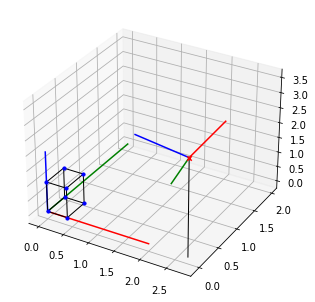

In [373]:
from utils import plot_box_and_camera
plot_box_and_camera(initial_box_points_3d, camera_center, wRc_T.T)

## Human Pose Estimation
In this part, we will use [mediapipe](https://google.github.io/mediapipe/) to do pose estimate from videos. As an important task of computer vision, human Pose Estimation is defined as the problem of localization of human joints (also known as keypoints - elbows, wrists, etc) in images or videos. It has great application in many real-life situations, such as action recognition, AR/VR, animation, gaming, etc.

The official [document](https://google.github.io/mediapipe/solutions/pose#overview) on pose estimation also provides some more detailed explanation, examples, and tutorial about how to use the python version of pose estimation can be found [there](https://google.github.io/mediapipe/solutions/pose#python).


### Detect human pose from images


Detected landmark numbers:  33


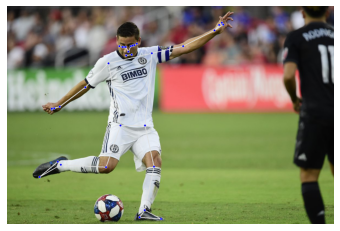

In [374]:
player_test_img='../data/player1.jpg'

player_land_mark, annotated_image = student_code.hand_pose_img(player_test_img)
print('Detected landmark numbers: ', len(player_land_mark))
utils.imshow1(annotated_image)

In [ ]:
# Although this is actually the right toe physically, 
# we can call it left toe for now in this notebook, to be consistent with 
# the name convention used in mediapipe's pose estimation.

left_toe = player_land_mark[32]
print(left_toe)

## Projection of 2D pose estimation to 3D world coordinates
In this section, we're going to project the 2D human pose estimation onto the 3D coordinates in the world frame (or to be more specific, the chair-center frame). (to do this we will have to tell how far the person is from the camera)

The projection function is pretty similar to the one you implement in project 5, except that we project from 2D to 3D instead of 3D to 2D. We use camera matrix $P \in R^{3×4}$ as a projective mapping from world (3D) to pixel (2D) coordinates defined up to a scale.

\begin{align}
z\begin{bmatrix}
x_p\\
y_p\\
1
\end{bmatrix}
=
\mathbf
{P}
\begin{bmatrix}
x_w\\
y_w\\
z_w\\
1
\end{bmatrix}
\end{align}

The camera matrix can also be decomposed into intrinsic parameters K and extrinsic parameters ${}^w \mathbf{R}_c, \: {}^w \mathbf{t}_c$.

$\mathbf{P} = \mathbf{K} \: {}^w \mathbf{R}_c^\top [\mathbf{I}\;|\; -{}^w \mathbf{t}_c].$

\begin{align}
\mathbf
{P}=
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

Generally, we cannot fully recover the 3D coordinates from a 2D feature points because the depth information is lost. As such, you're asked to provide the depth information (i.e., $z$ in the projection equation above.) The physical meaning of depth is the physical distance between human in the picture and the camera in meters.


To make things clear, in this project, you have to work with three coordinate frames in total. The world frame (which is defined as the chair frame, 3D), the camera-centric frame (3D), and the image frame (2D). In this sectrion, you will project feature points in 2D image frame to the 3D chair frame.

In [377]:
P = K.dot(wRc_T.dot( np.hstack((np.eye(3),-1.0*camera_center)) ))

In [378]:
depth = 1.91

student_land_mark, _ = student_code.hand_pose_img(student_test_img)
pose3d_landmark = student_code.projection_2d_to_3d(P, depth, student_land_mark)

left_hand = pose3d_landmark[22]
print("Your 3D pose landmark of the left hand is ", left_hand)

Your 3D pose landmark of the left hand is  [-0.16259547  1.26188933  0.60657772]
Testing your 3d human pose estimate:  "Correct"


In [379]:
# Test if you can project the 0 vertice back correctly
P.dot(np.array([0,0,0,1]).T)/P.dot(np.array([0,0,0,1]).T)[2]

array([8.34213014e+02, 3.08371398e+03, 1.00000000e+00])

## Intersection between Pose and Objectron



After detecting both the 3D coordinates of human pose and the 3D coordinates of 8 vertices of the chair, we can now finally apply our trick now. We will detect whether the hand is in the bounding box of the chair in this section (And you can try to detect other parts too). If so, then we would change the color of the bounding box to show it. (Black if no detection, a bight color if detection) Such kind of detection would be pretty useful for situations like collision check and obstacles avoidance.

(4032, 3024, 3)


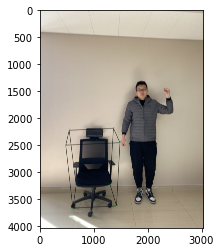

In [380]:
annotated_img = student_code.draw_box_intersection(img, left_hand, vertices_world, bounding_boxes_chair_2d)

plt.imshow(annotated_img)
plt.show()